<a href="https://colab.research.google.com/github/AditiShanmugam/Multi-Modal-Machine-Learning/blob/main/CLIP_FYP_Cereal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import subprocess
 
CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)
 
if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

CUDA version: 11.1


In [ ]:
!pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html
!pip install ftfy regex

import torch

print("Torch version:", torch.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Torch version: 1.7.1+cu110


In [ ]:
!git clone https://github.com/openai/CLIP.git
%cd CLIP
import clip

Cloning into 'CLIP'...
remote: Enumerating objects: 222, done.
remote: Total 222 (delta 0), reused 0 (delta 0), pack-reused 222
Receiving objects: 100% (222/222), 8.91 MiB | 30.63 MiB/s, done.
Resolving deltas: 100% (113/113), done.
/content/CLIP/CLIP


In [27]:
# Mount Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [28]:
# make directory to hold images
import os 

#if 'images' not in os.listdir():
#!mkdir /content/images/
# !rm -r /content/images/

# unzip and extract
# !cp -r /content/gdrive/MyDrive/Exotic_Food_Dataset/ExoticFood/ /content/images/
!unzip -uq '/content/gdrive/MyDrive/FinalYearProject-Group11/Datasets/Image_Database_Cereal.zip' -d "/content/images"

In [29]:
import os
image_urls = []
labels = []

path = '/content/images/Image_Database_Cereal'


for folder in os.listdir(path):
  if folder != '.DS_Store':
    for file in os.listdir(os.path.join(path, folder)):
      if file != '.DS_Store':
        url = os.path.join(path, folder, file)
        image_urls.append(url)
        name = folder#.replace('_',' ')
        labels.append(name)


print(f'# of images: {len(image_urls)}')
print(f'# of labels: {len(labels)}')

# of images: 318
# of labels: 318


In [30]:
print(image_urls[0])

/content/images/Image_Database_Cereal/All_Bran/All_Bran16.jpg


In [31]:
food_types = sorted(set(labels))
print(len(food_types))
food_types

12


['All_Bran',
 'Alpen',
 'Alpha_Bits',
 'Apple_Jacks',
 'Apple_Zings',
 'Baby_Shark_Cereal',
 'Blueberry_Muffin_Toasters',
 'Boo_Berry',
 'Capn_Crunch',
 'Chocolatey_Berry_Crunch',
 'Cinnamon_Toast_Crunch',
 'Vita_Brits']

In [32]:
class_to_idx = {v:k for k,v in enumerate(food_types)}
idx_to_class = {k:v for v,k in class_to_idx.items()}

list_of_targets = [class_to_idx[label] for label in labels]

In [33]:
import pandas as pd
df = pd.DataFrame(list(zip(image_urls, labels, list_of_targets)), columns = ['image_urls', 'labels', 'targets'])

In [34]:
df.head()

,image_urls,labels,targets
0,/content/images/Image_Database_Cereal/All_Bran...,All_Bran,0
1,/content/images/Image_Database_Cereal/All_Bran...,All_Bran,0
2,/content/images/Image_Database_Cereal/All_Bran...,All_Bran,0
3,/content/images/Image_Database_Cereal/All_Bran...,All_Bran,0
4,/content/images/Image_Database_Cereal/All_Bran...,All_Bran,0


In [35]:
class CustomDatasetFromImages(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform):
        """
        Args:
            csv_path (string): path to csv file
            img_path (string): path to the folder where images are
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.data_info = dataframe
        self.image_arr = np.asarray(self.data_info.iloc[:, 0])
        self.label_arr = np.asarray(self.data_info.iloc[:, 2])
        self.data_len = len(self.data_info.index)
        self.transforms = transform

    def __getitem__(self, index):
        single_image_name = self.image_arr[index]
        img_as_img = Image.open(single_image_name).convert("RGB")
        tensor_image = self.transforms(img_as_img)
        single_image_label = self.label_arr[index]

        return (tensor_image, single_image_label)

    def __len__(self):
        return self.data_len

In [37]:
from torch.utils.data import DataLoader
from PIL import Image
from tqdm import tqdm
import numpy as np

if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

model, preprocess = clip.load("ViT-B/32", device=device) #loading the clip checkpoints
dataset = CustomDatasetFromImages(df, transform=preprocess)

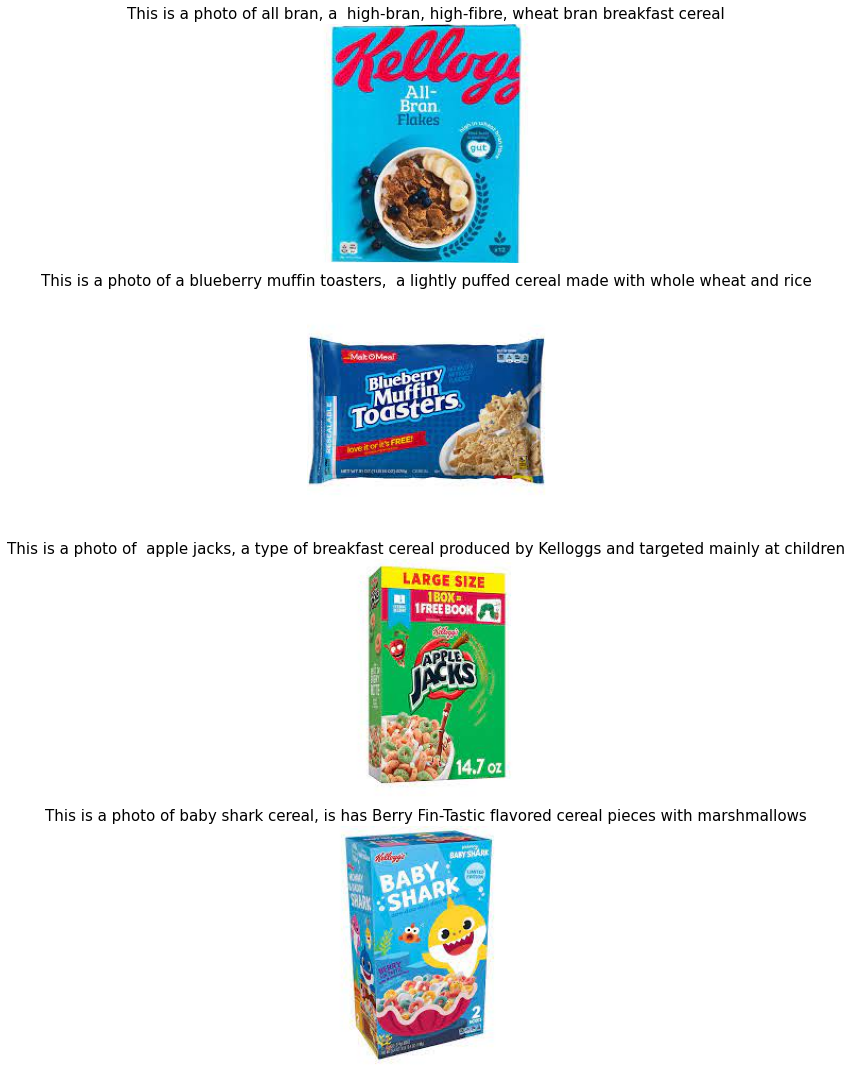

In [38]:
import cv2
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(15, 15))

images = []
texts = []
image1 = cv2.imread('/content/images/Image_Database_Cereal/All_Bran/All_Bran0.jpg')
RGB_img1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.imread('/content/images/Image_Database_Cereal/Blueberry_Muffin_Toasters/Blueberry_Muffin_Toasters0.jpg')
RGB_img2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
image3 = cv2.imread('/content/images/Image_Database_Cereal/Apple_Jacks/Apple_Jacks0.jpg')
RGB_img3 = cv2.cvtColor(image3, cv2.COLOR_BGR2RGB)
image4 = cv2.imread('/content/images/Image_Database_Cereal/Baby_Shark_Cereal/Baby_Shark_Cereal0.jpg')
RGB_img4 = cv2.cvtColor(image4, cv2.COLOR_BGR2RGB)
rows = 4
columns = 1

fig.add_subplot(rows, columns, 1)
# showing image
plt.imshow(RGB_img1)
plt.axis('off')
plt.title("This is a photo of all bran, a  high-bran, high-fibre, wheat bran breakfast cereal", fontsize=15)
fig.add_subplot(rows, columns, 2)
plt.imshow(RGB_img2)
plt.axis('off')
plt.title("This is a photo of a blueberry muffin toasters,  a lightly puffed cereal made with whole wheat and rice", fontsize=15)
fig.add_subplot(rows, columns, 3)
plt.imshow(RGB_img3)
plt.axis('off')
plt.title("This is a photo of  apple jacks, a type of breakfast cereal produced by Kelloggs and targeted mainly at children", fontsize=15)
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
# showing image
plt.imshow(RGB_img4)
plt.axis('off')
plt.title("This is a photo of baby shark cereal, is has Berry Fin-Tastic flavored cereal pieces with marshmallows", fontsize=15)
plt.tight_layout()

#Linear Probe

In [39]:
torch.manual_seed(42)

def get_features(dataset):
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset, batch_size=50)):
            features = model.encode_image(images.to(device))

            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

In [40]:
features, labels = get_features(dataset)

100%|██████████| 7/7 [00:45<00:00,  6.51s/it]


In [41]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

#Evaluate L2 regularization strengths for reducing features in final model 
C = [1, 5, 10, 11, 12, 13, 14, 15] # As C decreases, more coefficients go to zero

for c in C:
    clf = LogisticRegression(penalty='l2', C=c, solver='liblinear', class_weight="balanced")

    # using data before splitting (X=features) and (y=labels)
    scores = np.mean(cross_val_score(clf, features, labels, cv=5, scoring="accuracy"))  #<-- add this
    print(scores)  #<-- add this

0.9812003968253968
0.9812003968253968
0.9843253968253969
0.9843253968253969
0.9843253968253969
0.9843253968253969
0.9843253968253969
0.9843253968253969


In [42]:
seed = [0, 42, 96, 100, 201]
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, #Change test size when deploying model
                                                    random_state=seed[1], stratify=labels)

In [43]:
model = LogisticRegression(random_state=seed[1], penalty='l2', 
                         C=1, solver='liblinear', 
                         class_weight="balanced")


scores = cross_val_score(model, features, 
                         labels, cv=10, 
                         scoring="accuracy")

print("Scores are:")
print(scores)
print(f"======\nMean score is: {np.mean(scores)}")

Scores are:
[1.      1.      0.9375  0.96875 1.      1.      0.96875 1.      1.
 1.     ]
Mean score is: 0.9875


In [44]:
classifier = LogisticRegression(random_state=seed[1], C=1, verbose=1, solver='liblinear', penalty='l2')
classifier.fit(X_train, y_train)

[LibLinear]

LogisticRegression(C=1, random_state=42, solver='liblinear', verbose=1)

In [45]:
def get_topk(classifier, X_test, y_test, top_k = (1, 5)):
  predictions = classifier.predict(X_test)
  probs = classifier.predict_proba(X_test)
  _max = max(top_k)
  best = np.argsort(probs, axis=1)[:,-(_max):]
  pred = torch.from_numpy(np.transpose(best))
  target = torch.from_numpy(y_test)
  correct = pred.eq(target.view(1, -1).expand_as(pred))
  res = []
  for k in top_k:
    correct_k = correct[:k].reshape(-1).float().sum(0)
    res.append(correct_k.mul_(100.0 / len(y_test)))
  inter_tensor = torch.stack(res)
  top5 = inter_tensor.data[1].item()
  top1 = np.mean((y_test == predictions))*100
  print(f'Top 1 accuracy is {top1}'.format(top1))
  print(f'Top {_max} accuracy is {top5}'.format(_max, top5))

In [46]:
get_topk(classifier, X_test, y_test, top_k = (1, 5))

Top 1 accuracy is 96.875
Top 5 accuracy is 100.0


In [47]:
from sklearn.metrics import confusion_matrix

predictions = classifier.predict(X_test)
conf_mat=confusion_matrix(y_test, predictions)
conf_mat = conf_mat / conf_mat.astype(np.float).sum(axis=1, keepdims=True)
# conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


''

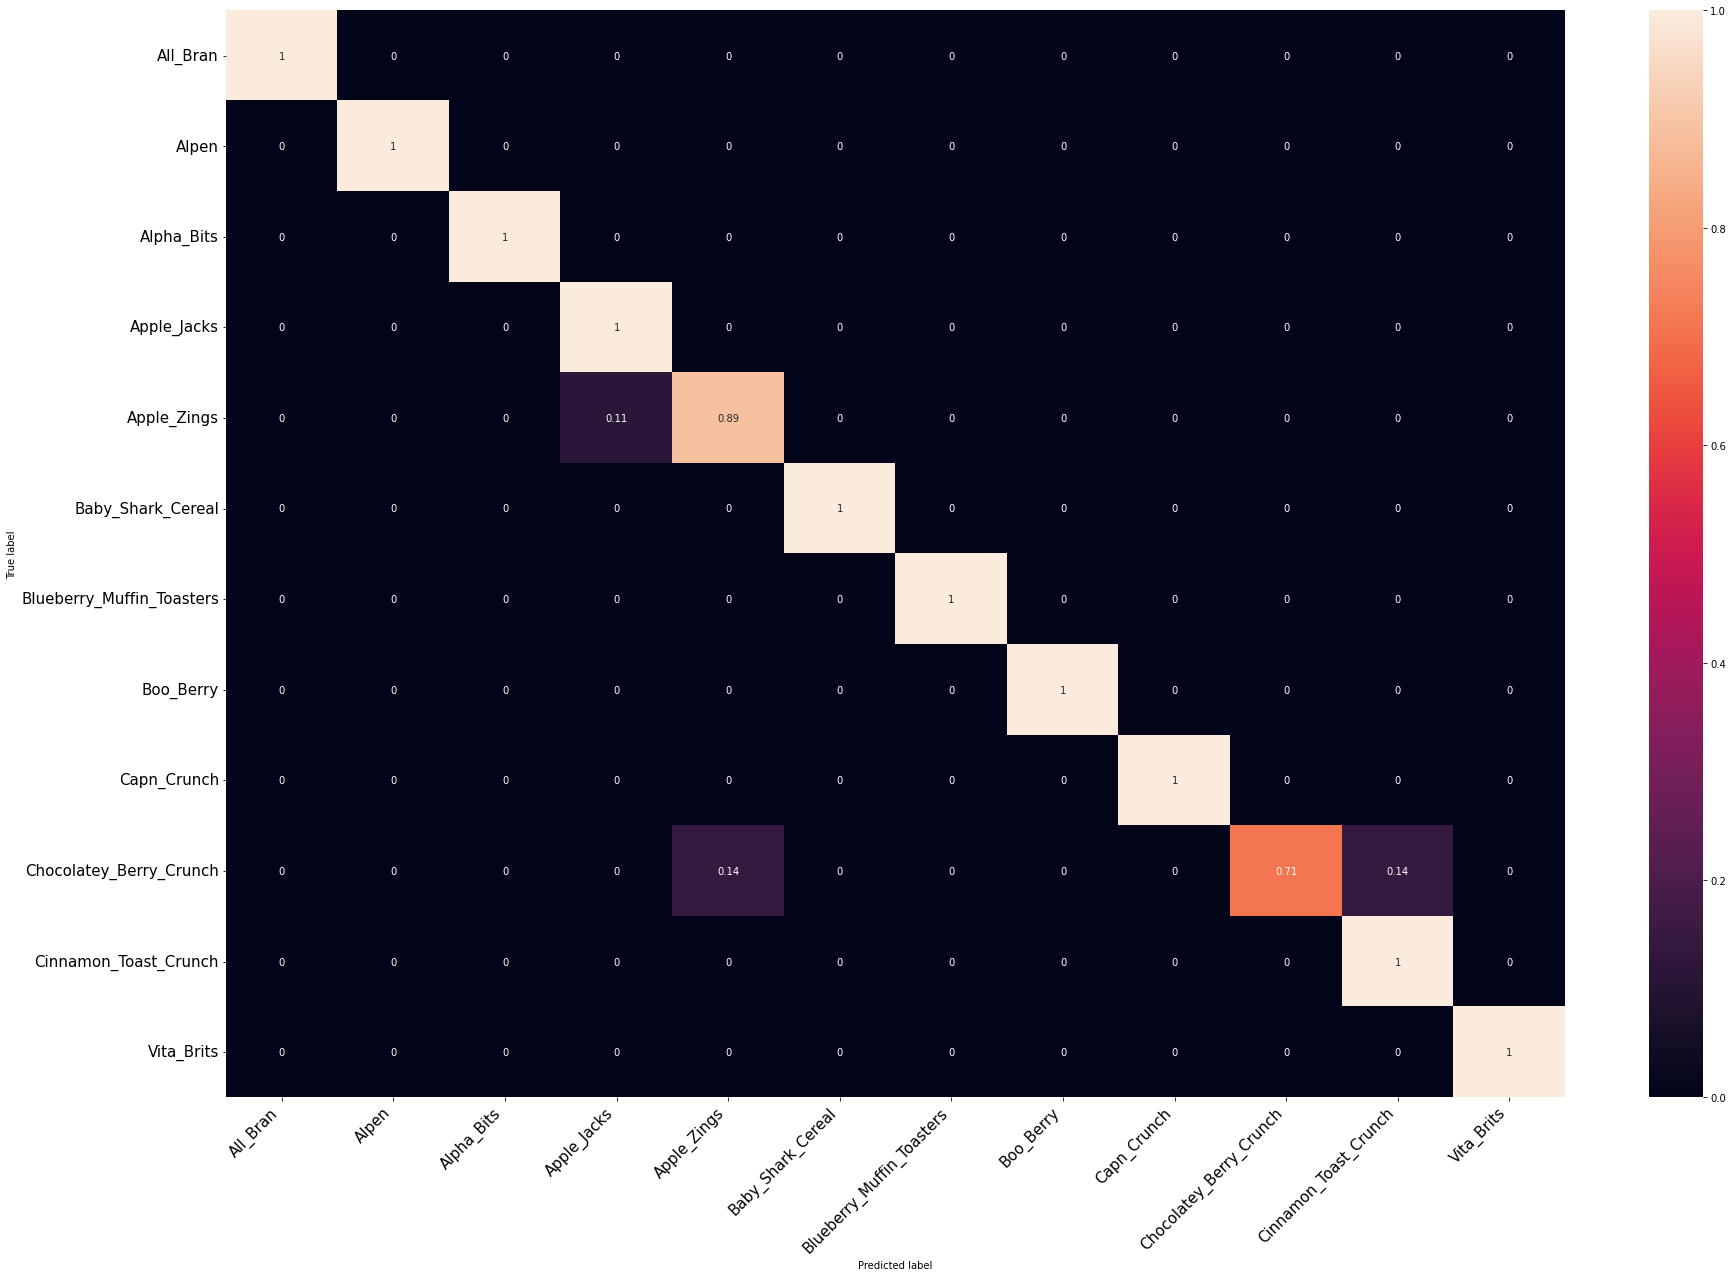

In [48]:
pd.set_option('display.max_rows', None)
import seaborn as sns

plt.figure(figsize=(30,20))

class_names = food_types
df_cm = pd.DataFrame(conf_mat, index=class_names, columns=class_names).astype(float)
df_cm
heatmap = sns.heatmap(df_cm, annot=True) #, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
;

#Zero-Shot

In [49]:
model, preprocess = clip.load("ViT-B/32", device=device) #loading the clip checkpoints
dataset = CustomDatasetFromImages(df, transform=preprocess)

torch.manual_seed(42)

def get_features(dataset):
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset, batch_size=8)):
            features = model.encode_image(images.to(device))

            all_features.append(features)
            all_labels.append(labels)

    # return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()
    
    #return tensor for images and array for labels
    return torch.cat(all_features), torch.cat(all_labels).cpu().numpy()

In [50]:
image_features, labels = get_features(dataset)

100%|██████████| 40/40 [00:56<00:00,  1.41s/it]


In [51]:
print(image_features.shape)
print(labels.shape)

torch.Size([318, 512])
(318,)


In [52]:
texts = [f"This is a photo of {c}, a type of exotic food. It is exotically delicious." for c in food_types]

In [53]:
text_inputs = clip.tokenize(texts).to(device)

In [54]:
def get_topk(text_inputs, image_features, labels, top_k=(1,2)):
  
  torch.cuda.empty_cache()

  with torch.no_grad():
    text_features = model.encode_text(text_inputs).float()
    # image_features = image_features
    # image_features = torch.from_numpy(image_features)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    _max = max(top_k)

    test_probs, test_labels = text_probs.cpu().topk(1, dim=-1) # calculate for confusion matrix
    predictions = np.concatenate(test_labels.cpu().numpy()) # calculate for confusion matrix
    
    top_probs, top_labels = text_probs.cpu().topk(_max, dim=-1) # calculate for actual top-1, top-5
    pred = top_labels.t()
    target = torch.from_numpy(labels)
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    res = []
    for k in top_k:
      correct_k = correct[:k].reshape(-1).float().sum(0)
      res.append(correct_k.mul_(100.0 / len(labels)))
    inter_tensor = torch.stack(res)
    top1 = inter_tensor.data[0].item()
    top2 = inter_tensor.data[1].item()
    print(f'Top 1 accuracy is {top1:.2f}'.format(top1)) # print top-1
    print(f'Top {_max} accuracy is {top2:.2f}'.format({_max}, top2)) # print top-2

    return predictions # return for confusion matrix

In [55]:
predictions = get_topk(text_inputs, image_features, labels, top_k=(1,2))

Top 1 accuracy is 84.59
Top 2 accuracy is 95.60


In [56]:
predictions = get_topk(text_inputs, image_features, labels, top_k=(1,3))

Top 1 accuracy is 84.59
Top 3 accuracy is 96.86


In [57]:
predictions = get_topk(text_inputs, image_features, labels, top_k=(1,5))

Top 1 accuracy is 84.59
Top 5 accuracy is 99.37


In [58]:
predictions.shape

(318,)

In [59]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(labels, predictions)
conf_mat = conf_mat / conf_mat.astype(np.float).sum(axis=1, keepdims=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


''

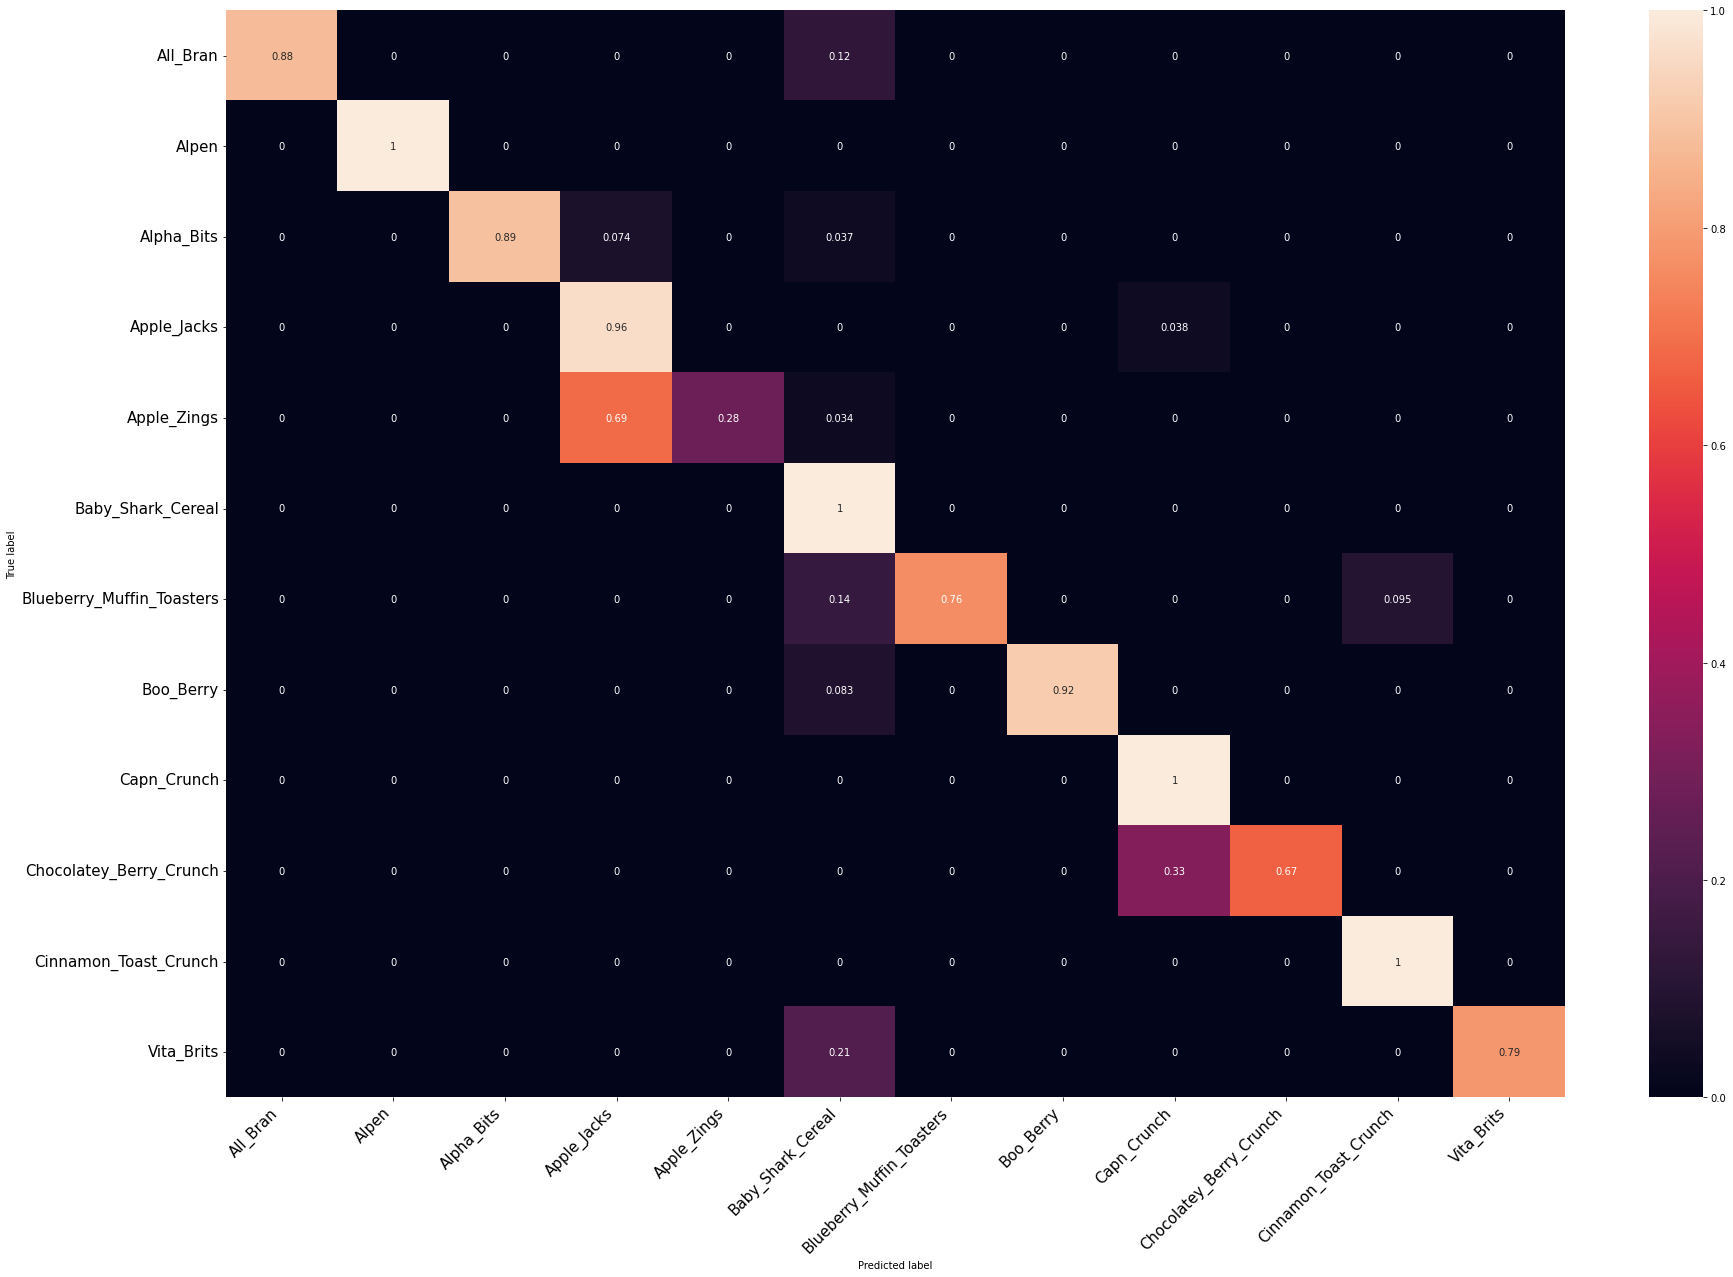

In [60]:
# %load_ext google.colab.data_table

pd.set_option('display.max_rows', None)
import seaborn as sns

plt.figure(figsize=(30,20))

class_names = food_types

df_cm = pd.DataFrame(conf_mat, index=class_names, columns=class_names).astype(float)
heatmap = sns.heatmap(df_cm, annot=True) #, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
;